In [7]:
import numpy as np
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt

import pandas as pd

from glob import glob
import matplotlib.path as pat
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib notebook
from astropy.modeling.functional_models import Gaussian2D
from scipy.signal import fftconvolve

from astropy.stats import sigma_clipped_stats
import os

import sys
sys.path.append('../../src/scenes/')
from correct_saturation import saturated_stars, image2counts, query_ps1

from pad_skycell import pad_skycell

In [8]:
skycells = pd.read_csv('../SkyCells/Sector020/skycell_s20_c1.csv')
ps1_file = glob('../data/ps1_skycell/rings.v3.skycell.*.stk.r.unconv.fits')
#pad = pad_skycell(ps1_file[0],skycells,'../data/ps1_skycell/',pad = 500,plot=True)#,catalog=cat)

In [10]:
WCS(ps1_file[1])

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 123.749999999996 45.9999999999984 
CRPIX : -11416.0 17669.0 
PC1_1 PC1_2  : -1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 6.94444461259988e-05 6.94444461259988e-05 
NAXIS : 6307  6289

In [4]:
#ps1_file = glob('../data/ps1_skycell/rings.v3.skycell.2246.013.stk.r.unconv.fits')

data = fits.open(ps1_file[-2])[0].data
wcs = WCS(ps1_file[-2])

path = Path(wcs.calc_footprint())

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [5]:
ra,dec = wcs.all_pix2world(data.shape[0]/2,data.shape[1]/2,0)
cat = query_ps1(ra,dec,0.40)

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


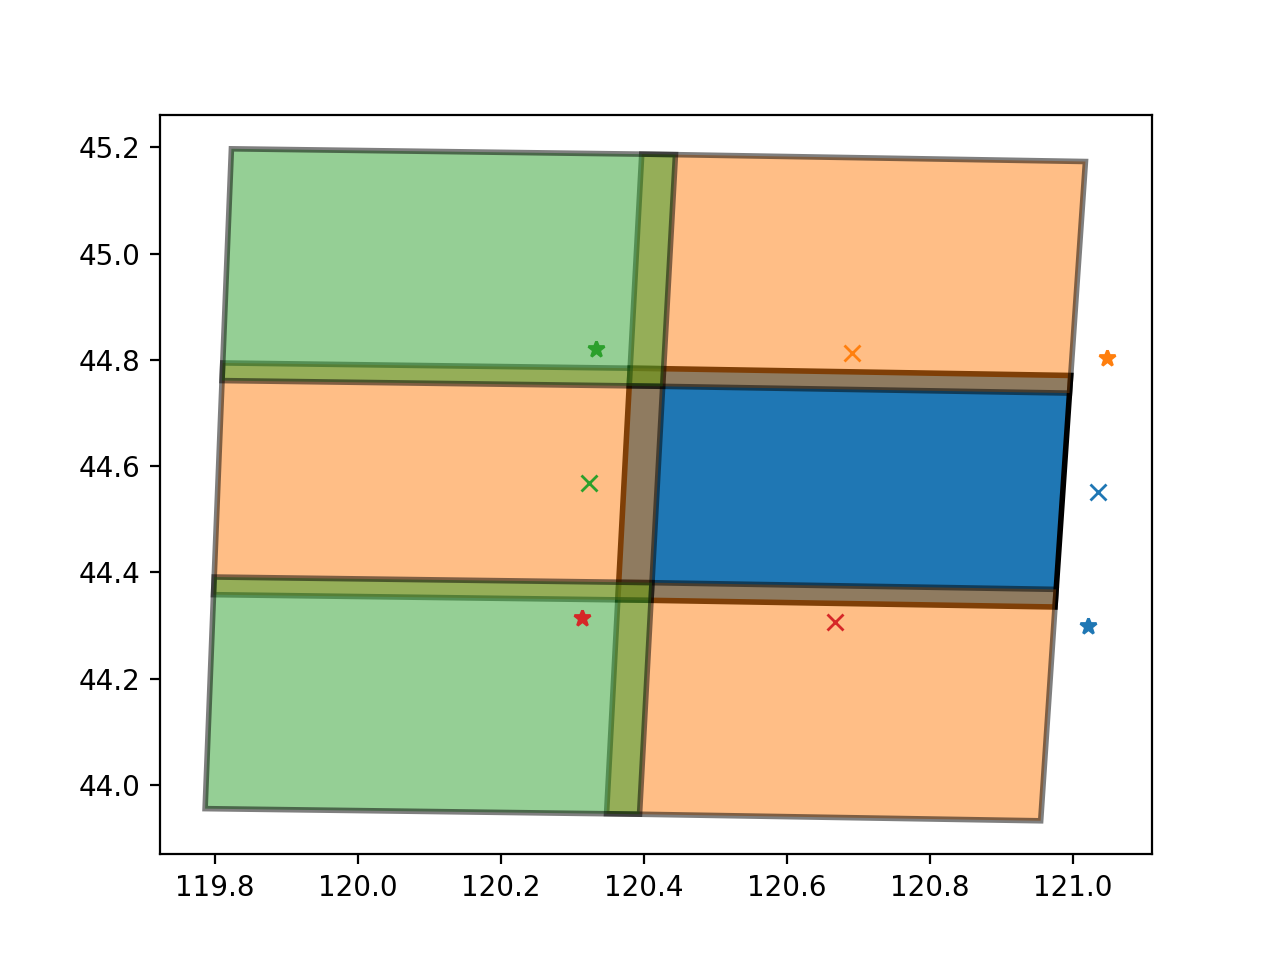

<IPython.core.display.Javascript object>


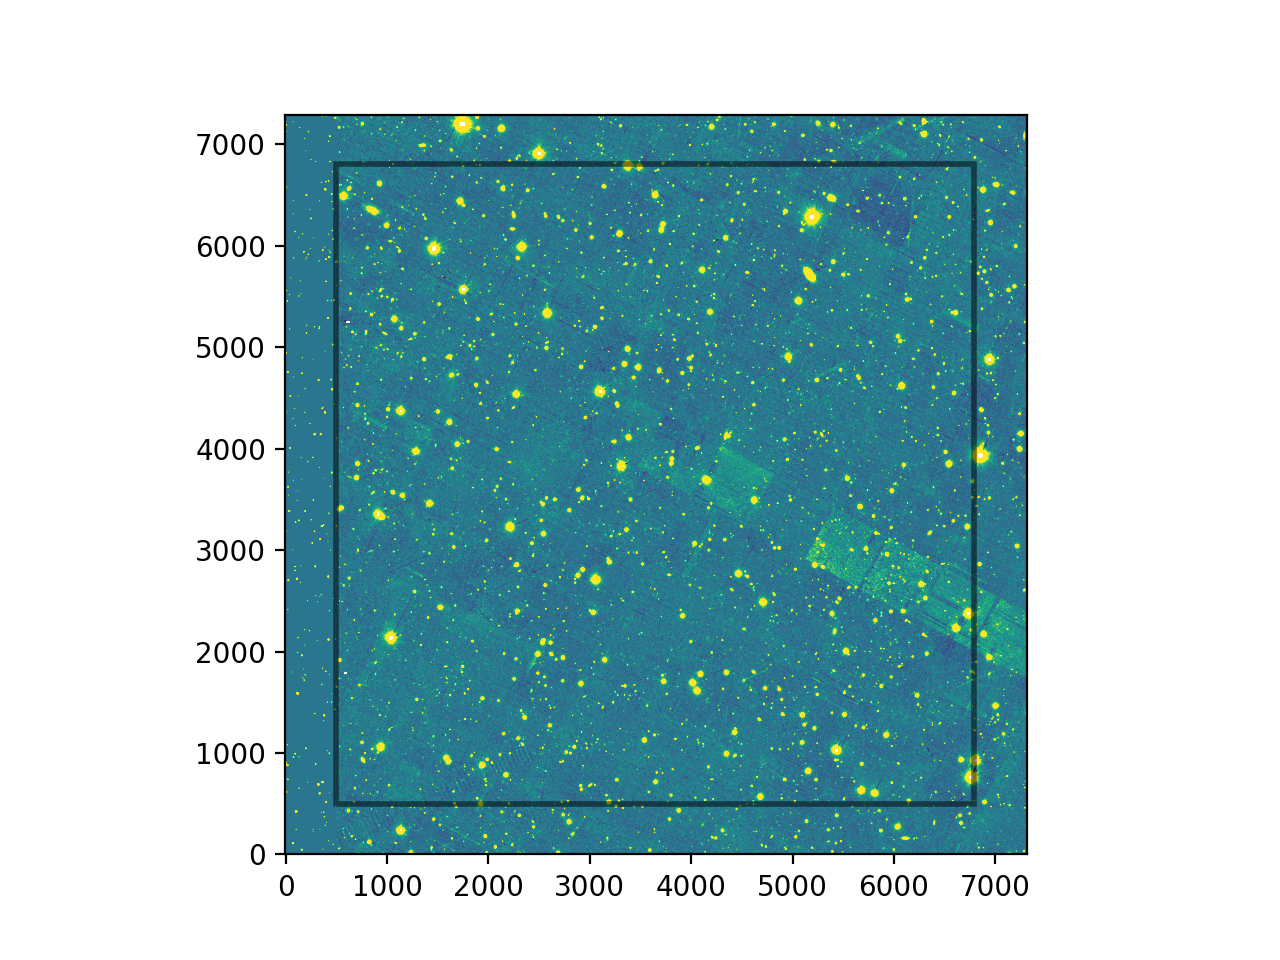

In [6]:
pad = pad_skycell(ps1_file[-2],skycells,'../data/ps1_skycell/',pad = 500,plot=True,catalog=cat)

In [144]:
class pad_skycell():
    def __init__(self,file,skycells,datapath,pad=500,
                 catalog=None,psf_std=2.5,run=True,download=True,
                 plot=False):
        self.file = file
        self.datapath = datapath 
        self.pad = pad
        self.skycells = skycells
        self._check_download = download
        self.cat = catalog
        self.psf_std = psf_std
        
        self._load_image()
        
        # set by ps1
        self.overlap = 240 * 2 # overlap pixels
    
        if run:
            self.run()
            if plot:
                self.plot_cells()
                self.plot_image()
        
        
    def _load_image(self):
        hdul = fits.open(self.file)
        if len(hdul) == 1:
            j = 0 
        else:
            j = 1
        self.data = hdul[j].data
        self.header = hdul[j].header
        self.wcs = WCS(hdul[j].header)
        hdul.close()
        self.im_skycell = int(self.file.split('skycell.')[-1].split('.')[0])
        self.band = self.file.split('stk.')[-1].split('.')[0]
        self.padded = np.pad(self.data,self.pad)
        self.zp = 25 + 2.5*np.log10(self.header['EXPTIME'])
    
    def run(self):
        self._ovsersize_points()
        self._check_skycells()
        self._skycell_poly()
        self._intersecting_points()
        self._pad_sides()
        self._pad_corners()
        self._cat_fill()
        
    
    def _ovsersize_points(self):
        pad = self.pad
        pc_y,pc_x = self.wcs.array_shape 
        pc_y /= 2; pc_x /= 2

        oversize_points = np.array([[-pad, pc_y], # clockwise from left side
                                    [pc_x, 2*pc_y+pad],
                                    [2*pc_x+pad, pc_y],
                                    [pc_x, -pad]])

        oversize_corners = np.array([[-pad,-pad], # Clockwise from lower left 
                                    [-pad, 2*pc_y+pad],
                                    [2*pc_x+pad, 2*pc_y+pad],
                                    [2*pc_x+pad, -pad]])
        
        oversized_edges = self.wcs.all_pix2world(oversize_points,0)
        oversized_corners = self.wcs.all_pix2world(oversize_corners,0)
        self.oversized_edges = oversized_edges
        self.oversized_corners = oversized_corners
        
    def _check_skycells(self):
        f = np.array([int(a.split('.')[1]) for a in self.skycells['Name'].values])
        ind = f == self.im_skycell
        self.skycells = self.skycells.iloc[ind]
        
        
    
    def _skycell_poly(self):
        skycells = self.skycells
        corner1 = SkyCoord(skycells['RA_Corner1'].values,skycells['DEC_Corner1'].values,unit='deg')
        corner2 = SkyCoord(skycells['RA_Corner2'].values,skycells['DEC_Corner2'].values,unit='deg')
        corner3 = SkyCoord(skycells['RA_Corner3'].values,skycells['DEC_Corner3'].values,unit='deg')
        corner4 = SkyCoord(skycells['RA_Corner4'].values,skycells['DEC_Corner4'].values,unit='deg')

        paths = []
        for i in range(len(skycells)):
            box = np.array([[skycells['RA_Corner1'].values[i],skycells['DEC_Corner1'].values[i]],
                            [skycells['RA_Corner2'].values[i],skycells['DEC_Corner2'].values[i]],
                            [skycells['RA_Corner3'].values[i],skycells['DEC_Corner3'].values[i]],
                            [skycells['RA_Corner4'].values[i],skycells['DEC_Corner4'].values[i]]])
            paths += [Path(box)]
        paths = np.array(paths)
        self.skycell_paths = paths
        
    
    def _intersecting_points(self):
        
        matched = []
        for p in self.skycell_paths:
            matched += [p.contains_points(self.oversized_edges)]
        matched = np.array(matched)
        side_cells = np.where(matched) # 0: cell index; 1: side index


        matched = []
        for p in self.skycell_paths:
            matched += [p.contains_points(self.oversized_corners)]
        matched = np.array(matched)
        corner_cells = np.where(matched) # 0: cell index; 1: corner index
        
        
        self.side_cells = side_cells
        self.corner_cells = corner_cells
        if self._check_download:
            download_skycells(self.skycells['Name'].values[side_cells[0]],path=self.datapath,filters=[self.band])
            download_skycells(self.skycells['Name'].values[corner_cells[0]],path=self.datapath,filters=[self.band])
        
    
    def _pad_sides(self):
        side_cells = self.side_cells
        pad = self.pad
        overlap = self.overlap
        for i in range(len(side_cells[0])):
            name = self.skycells.iloc[side_cells[0]].Name.values[i]
            side = side_cells[1][i]
            filename = f'rings.v3.{name}.stk.{self.band}.unconv.fits'
            hdul = fits.open(self.datapath + filename)
            if len(hdul) == 1:
                j = 0 
            else:
                j = 1
            buff = hdul[j].data

            if side == 0:
                self.padded[pad:-pad,:pad+10] = buff[:,-(pad+overlap):-overlap+10]
            elif side == 1:
                self.padded[-(pad+10):,pad:-pad] = buff[overlap-10:(pad+overlap),:]
            elif side == 2:
                self.padded[pad:-pad,-(pad+10):] = buff[:,overlap-10:(pad+overlap)]
            elif side == 3:
                self.padded[:pad+10,pad:-pad] = buff[-(pad+overlap):-overlap+10,:]
        
    def _pad_corners(self):
        corner_cells = self.corner_cells
        pad = self.pad
        overlap = self.overlap
        for i in range(len(corner_cells[0])):
            name = self.skycells.iloc[corner_cells[0]].Name.values[i]
            corner = corner_cells[1][i]
            filename = f'rings.v3.{name}.stk.{self.band}.unconv.fits'
            hdul = fits.open(self.datapath + filename)
            if len(hdul) == 1:
                j = 0 
            else:
                j = 1
            buff = hdul[j].data
            if corner == 0:
                self.padded[:(pad+10),:(pad+10)] = buff[-(pad+overlap):-overlap+10,-(pad+overlap):-overlap+10]
            elif corner == 1:
                self.padded[-(pad+10):,:(pad+10)] = buff[overlap-10:(pad+overlap),-(pad+overlap):-overlap+10]
            elif corner == 2:
                self.padded[-(pad+10):,-(pad+10):] = buff[overlap-10:(pad+overlap),overlap-10:(pad+overlap)]
            elif corner == 3:
                self.padded[:pad+10,-pad-10:] = buff[-(pad+overlap):-overlap+10,overlap-10:(pad+overlap)]
    
    def _cat_fill(self):
        sides = []; corners = []
        if len(self.side_cells[1]) < 4:
            sides = set(np.arange(0,4))
            done = set(self.side_cells[1])
            sides = np.array(list(sides - done))
        if len(self.corner_cells[1]) < 4:
            corners = set(np.arange(0,4))
            done = set(self.corner_cells[1])
            corners = np.array(list(corners - done))
        
        if (len(sides) > 0) & (len(corners) > 0):
            if self.cat is not None:
                cat = self.cat
                x,y = self.wcs.all_world2pix(cat['raMean'].values,cat['decMean'].values,0)
                x += self.pad; y += self.pad
                cat['x'] = x.astype(int); cat['y'] = y.astype(int)
                ind = (x > 0) & (y > 0) & (x < self.padded.shape[1]) & (y < self.padded.shape[0])
                cat = cat.iloc[ind]
                cat_image = np.zeros_like(self.padded)
                ind_image = self._catpad_index(sides,corners)
                ind = ind_image[cat['y'].values,cat['x'].values] == 1
                cat = cat.iloc[ind]
                self.cat = cat
                #cat_image[cat['y'].values,cat['x'].values] = catmag_to_imscale(cat[f'{self.band}MeanPSFMag'].values,self.header)
                cat_image[cat['y'].values,cat['x'].values] = 10**((cat[f'{self.band}MeanPSFMag'].values-self.zp)/-2.5)
                g = Gaussian2D(x_stddev=self.psf_std,y_stddev=self.psf_std,x_mean=10,y_mean=10)
                y,x = np.mgrid[:21,:21]
                psf = g(x,y)
                psf /= np.nansum(psf)
                cat_image = fftconvolve(cat_image, psf, mode='same')
                cat_image = catmag_to_imscale(cat_image,self.header)
                m,med,std = sigma_clipped_stats(self.data)
                self.cat_image = cat_image
                self.ind_image = ind_image
                self.padded[ind_image > 0] = cat_image[ind_image > 0] + med
            else:
                print('No catalog provided!')
            
    def _catpad_index(self,sides,corners):
        pad = self.pad
        catpad = np.zeros_like(self.padded)
        for side in sides:
            if side == 0:
                catpad[pad:-pad,:pad+10] = 1
            elif side == 1:
                catpad[-(pad+10):,pad:-pad] = 1
            elif side == 2:
                catpad[pad:-pad,-(pad+10):] = 1
            elif side == 3:
                catpad[:pad+10,pad:-pad] = 1
        for corner in corners:
            if corner == 0:
                catpad[:(pad+10),:(pad+10)] = 1
            elif corner == 1:
                catpad[-(pad+10):,:(pad+10)] = 1
            elif corner == 2:
                catpad[-(pad+10):,-(pad+10):] = 1
            elif corner == 3:
                catpad[:pad+10,-pad-10:] = 1
            
        return catpad
    
    def plot_cells(self):
        path = Path(self.wcs.calc_footprint())
        plt.figure()
        colours = ['C0','C1','C2','C3']
        for p,c in zip(self.oversized_corners,colours):
            plt.plot(p[0],p[1],c+'*')
        for p,c in zip(self.oversized_edges,colours):
            plt.plot(p[0],p[1],c+'x')
            
        for a in [path]:
            codes = [
                Path.MOVETO,
                Path.LINETO,
                Path.LINETO,
                Path.LINETO,
                Path.CLOSEPOLY,
                ]
            a = a.vertices
            b = np.vstack((a,a[0]))
            test = Path(b,codes=codes)
            patch = patches.PathPatch(test, facecolor='C0', lw=2,alpha=1)
            plt.gca().add_patch(patch)

        for a in self.skycell_paths[self.side_cells[0]]:
            codes = [
                Path.MOVETO,
                Path.LINETO,
                Path.LINETO,
                Path.LINETO,
                Path.CLOSEPOLY,
                ]
            a = a.vertices
            b = np.vstack((a,a[0]))
            test = Path(b,codes=codes)
            patch = patches.PathPatch(test, facecolor='C1', lw=2,alpha=0.5)
            plt.gca().add_patch(patch)

        for a in self.skycell_paths[self.corner_cells[0]]:
            codes = [
                Path.MOVETO,
                Path.LINETO,
                Path.LINETO,
                Path.LINETO,
                Path.CLOSEPOLY,
                ]
            a = a.vertices
            b = np.vstack((a,a[0]))
            test = Path(b,codes=codes)
            patch = patches.PathPatch(test, facecolor='C2', lw=2,alpha=0.5)
            plt.gca().add_patch(patch)
            
    def plot_image(self):
        pad = self.pad
        pixel_path = np.array([[pad,pad],
                               [self.data.shape[0]+pad,pad],
                               [self.data.shape[0]+pad,self.data.shape[1]+pad],
                               [pad,self.data.shape[1]+pad]])
        path = Path(pixel_path)
        
        vmin = np.nanpercentile(self.padded,16)
        vmax = np.nanpercentile(self.padded,90)
        plt.figure()
        plt.imshow(self.padded,vmin=vmin,vmax=vmax,origin='lower')
        codes = [
                Path.MOVETO,
                Path.LINETO,
                Path.LINETO,
                Path.LINETO,
                Path.CLOSEPOLY,
                ]
        a = path.vertices
        b = np.vstack((a,a[0]))
        test = Path(b,codes=codes)
        patch = patches.PathPatch(test, facecolor='None', lw=2,alpha=0.5)
        plt.gca().add_patch(patch)


    

def catmag_to_imscale(flux,header):
    a = 2.5/np.log(10)
    tmp = (flux - header['boffset']) / (header['bsoften']*2)
    tmp = np.arcsinh(tmp)*a
    return tmp

def download_skycells(names,path,filters=['r','i','z','y'],overwrite=False):
    for name in names:
        for band in filters:
            filename = f'rings.v3.{name}.stk.{band}.unconv.fits'
            exist = glob(path + filename)
            if (len(exist) == 0) | overwrite:
                _,projection,cell = name.split('.')
                base = 'wget http://ps1images.stsci.edu//rings.v3.skycell/'
                call = base + f'{projection}/{cell}/{filename} -P {path}'
                os.system(call)
            else:
                pass
                #print(f'{filename} already exists.')

In [311]:
pad = 200

pc_y,pc_x = wcs.array_shape 
pc_y /= 2; pc_x /= 2

oversize_points = np.array([[-pad, pc_y], # clockwise from left side
                            [pc_x, 2*pc_y+pad],
                            [2*pc_x+pad, pc_y],
                            [pc_x, -pad]])

oversize_corners = np.array([[-pad,-pad], # Clockwise from lower left 
                            [-pad, 2*pc_y+pad],
                            [2*pc_x+pad, 2*pc_y+pad],
                            [2*pc_x+pad, -pad]])

oversized_edges = wcs.all_pix2world(oversize_points,0)
oversized_corners = wcs.all_pix2world(oversize_corners,0)

In [277]:
corner1 = SkyCoord(skycells['RA_Corner1'].values,skycells['DEC_Corner1'].values,unit='deg')
corner2 = SkyCoord(skycells['RA_Corner2'].values,skycells['DEC_Corner2'].values,unit='deg')
corner3 = SkyCoord(skycells['RA_Corner3'].values,skycells['DEC_Corner3'].values,unit='deg')
corner4 = SkyCoord(skycells['RA_Corner4'].values,skycells['DEC_Corner4'].values,unit='deg')

paths = []
for i in range(len(skycells)):
    box =np.array([[skycells['RA_Corner1'].values[i],skycells['DEC_Corner1'].values[i]],
              [skycells['RA_Corner2'].values[i],skycells['DEC_Corner2'].values[i]],
              [skycells['RA_Corner3'].values[i],skycells['DEC_Corner3'].values[i]],
              [skycells['RA_Corner4'].values[i],skycells['DEC_Corner4'].values[i]]])
    paths += [Path(box)]
paths = np.array(paths)

In [278]:

matched = []
for p in paths:
    matched += [p.contains_points(oversized_edges)]
matched = np.array(matched)
side_cells = np.where(matched) # 0: cell index; 1: side index


matched = []
for p in paths:
    matched += [p.contains_points(oversized_corners)]
matched = np.array(matched)
corner_cells = np.where(matched) # 0: cell index; 1: corner index

In [451]:
filename

'rings.v3.skycell.2246.024.stk.r.unconv.fits'

In [42]:
pad = pad_skycell(ps1_file[1],skycells,'../data/ps1_skycell/',pad = 500)

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


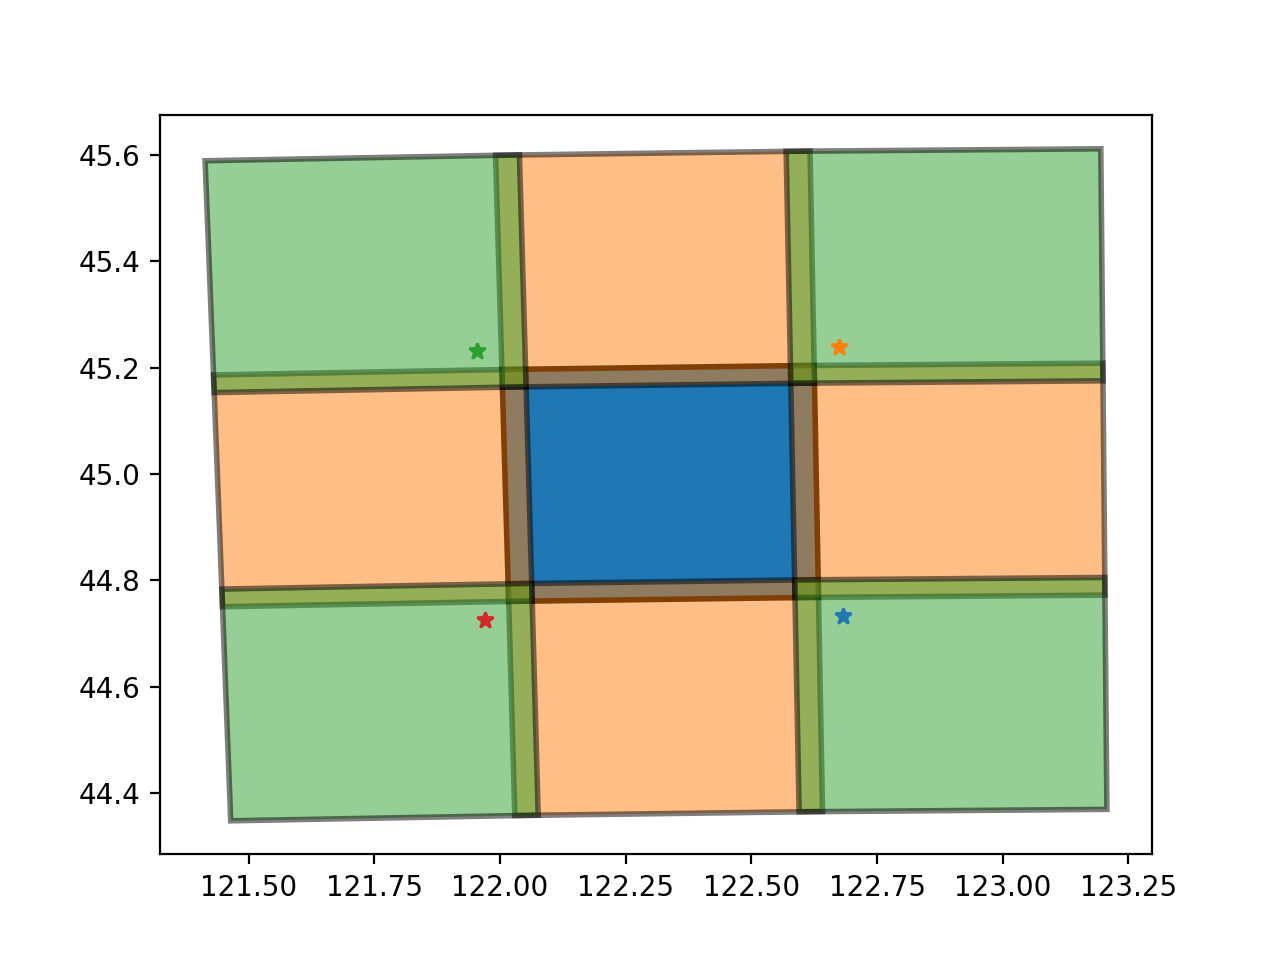

<IPython.core.display.Javascript object>


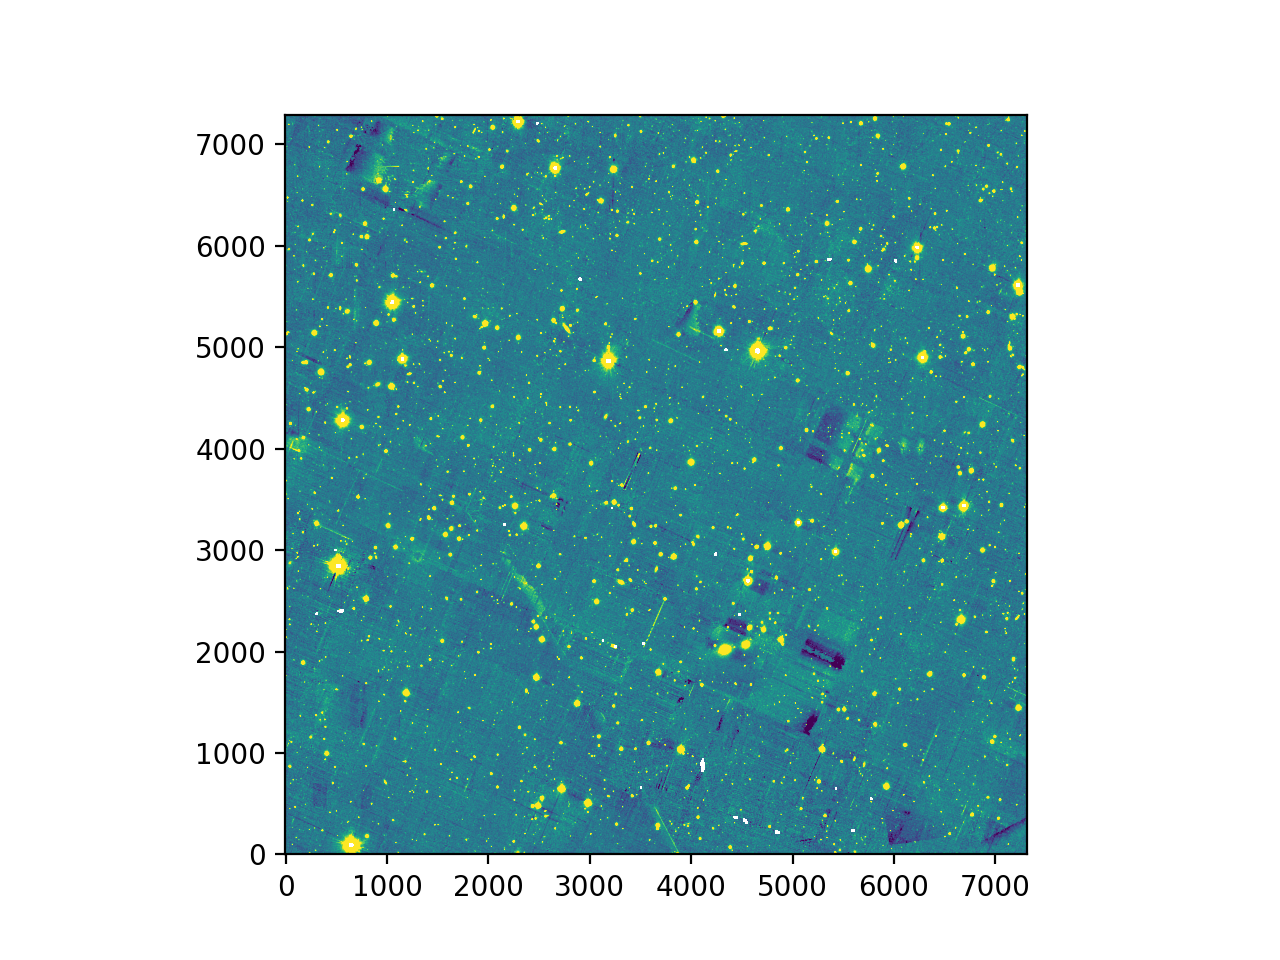

In [43]:
pad.plot_cells()
pad.plot_image()

In [21]:
ra,dec = wcs.all_pix2world(data.shape[0]/2,data.shape[1]/2,0)
cat = query_ps1(ra,dec,0.40)

In [22]:
x,y = wcs.all_world2pix(cat.raMean.values,cat.decMean.values,0)

In [18]:
pad = pad

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 123.749999999996 45.9999999999984 
CRPIX : -11416.0 17669.0 
PC1_1 PC1_2  : -1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 6.94444461259988e-05 6.94444461259988e-05 
NAXIS : 6307  6289

In [22]:
pad._ovsersize_points()

In [23]:
pad.oversized_corners

array([[-499., -499.],
       [-499., 6790.],
       [6808., 6790.],
       [6808., -499.]])

In [31]:
g = Gaussian2D(x_stddev=2.5,y_stddev=2.5,x_mean=10,y_mean=10)

In [37]:
y,x = np.mgrid[:21,:21]

In [38]:
psf = g(x,y)
psf /= np.nansum(psf)

<IPython.core.display.Javascript object>


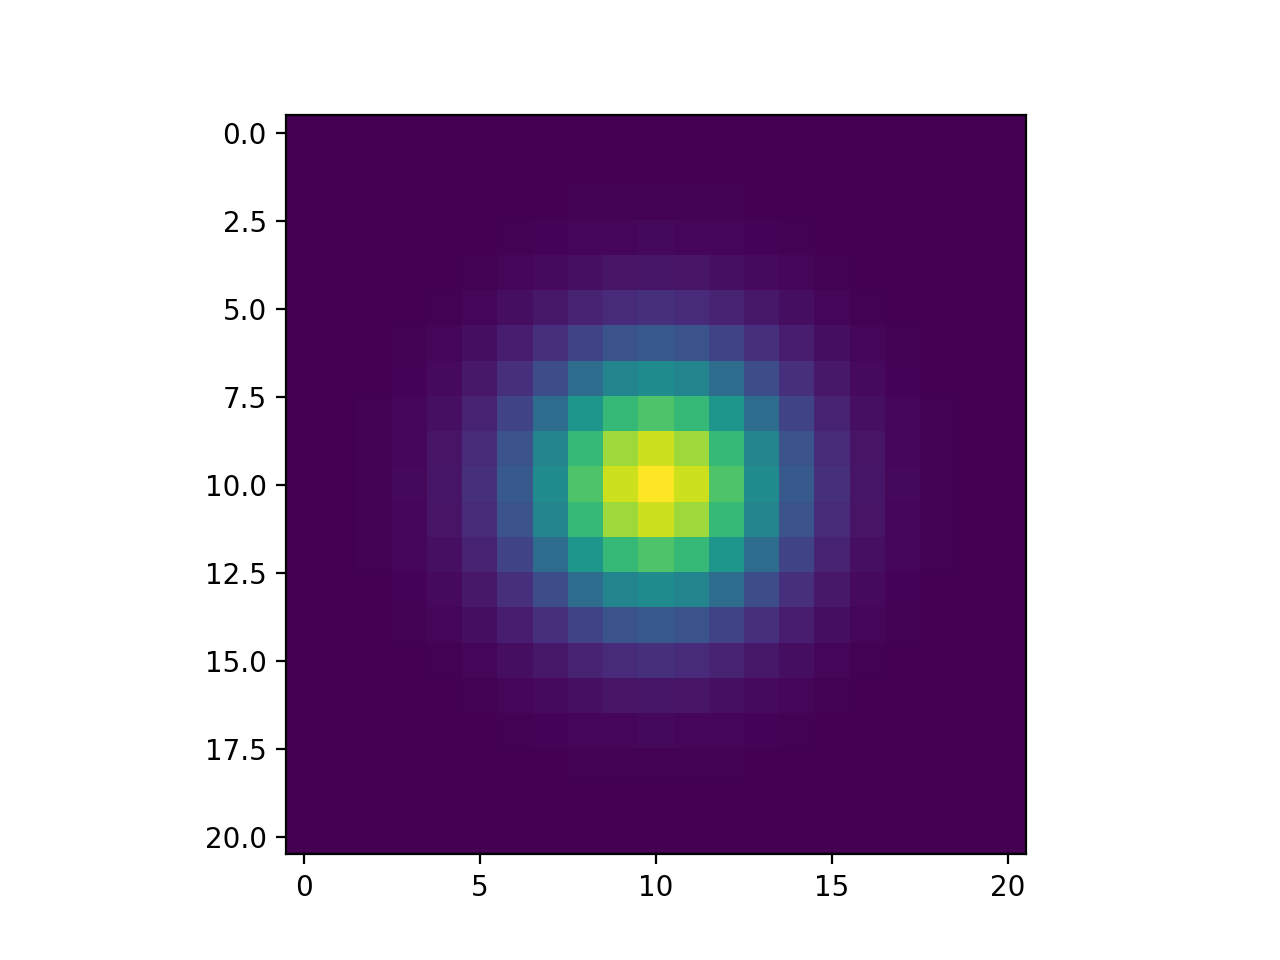

In [39]:
plt.figure()
plt.imshow(psf)

In [38]:
sides = np.arange(0,4)
done = np.arange(0,3)

In [40]:
s = set(sides) 
d = set(done)

In [44]:
np.array(list(s-d))

3

In [ ]:

def _pad_sides(padded,pad,):
    for i in range(len(side_cells[0])):
        name = skycells.iloc[side_cells[0]].Name.values[i]
        side = side_cells[1][i]
        filename = f'rings.v3.{name}.stk.{band}.unconv.fits'
        hdul = fits.open(path+filename)
        if len(hdul) == 1:
            j = 0 
        else:
            j = 1
        buff = hdul[j].data

        if side == 0:
            padded[pad:-pad,:pad+10] = buff[:,-(pad+overlap):-overlap+10]
        elif side == 1:
            padded[-(pad+10):,pad:-pad] = buff[overlap-10:(pad+overlap),:]
        elif side == 2:
            padded[pad:-pad,-(pad+10):] = buff[:,overlap-10:(pad+overlap)]
        elif side == 3:
            padded[:pad+10,pad:-pad] = buff[-(pad+overlap):-overlap+10,:]

def pad_PS1skycell(file,band,pad):
    
    overlap = 240 *2 
    
    ps1_file = glob(file)
    data = fits.open(ps1_file[0])[0].data
    wcs = WCS(ps1_file[0])
    
    pc_y,pc_x = wcs.array_shape 
    pc_y /= 2; pc_x /= 2

    oversize_points = np.array([[-pad, pc_y], # clockwise from left side
                                [pc_x, 2*pc_y+pad],
                                [2*pc_x+pad, pc_y],
                                [pc_x, -pad]])

    oversize_corners = np.array([[-pad,-pad], # Clockwise from lower left 
                                [-pad, 2*pc_y+pad],
                                [2*pc_x+pad, 2*pc_y+pad],
                                [2*pc_x+pad, -pad]])

    oversized_edges = wcs.all_pix2world(oversize_points,0)
    oversized_corners = wcs.all_pix2world(oversize_corners,0)
    
    
    

In [280]:
download_skycells(skycells.iloc[side_cells[0]].Name.values,path='../data/ps1_skycell/')

rings.v3.skycell.2246.003.stk.r.unconv.fits already exists.
rings.v3.skycell.2246.003.stk.i.unconv.fits already exists.
rings.v3.skycell.2246.003.stk.z.unconv.fits already exists.
rings.v3.skycell.2246.003.stk.y.unconv.fits already exists.
rings.v3.skycell.2246.012.stk.r.unconv.fits already exists.
rings.v3.skycell.2246.012.stk.i.unconv.fits already exists.
rings.v3.skycell.2246.012.stk.z.unconv.fits already exists.
rings.v3.skycell.2246.012.stk.y.unconv.fits already exists.
rings.v3.skycell.2246.014.stk.r.unconv.fits already exists.
rings.v3.skycell.2246.014.stk.i.unconv.fits already exists.
rings.v3.skycell.2246.014.stk.z.unconv.fits already exists.
rings.v3.skycell.2246.014.stk.y.unconv.fits already exists.
rings.v3.skycell.2246.023.stk.r.unconv.fits already exists.
rings.v3.skycell.2246.023.stk.i.unconv.fits already exists.
rings.v3.skycell.2246.023.stk.z.unconv.fits already exists.
rings.v3.skycell.2246.023.stk.y.unconv.fits already exists.


In [281]:
padded = np.pad(data,oversize)

<IPython.core.display.Javascript object>


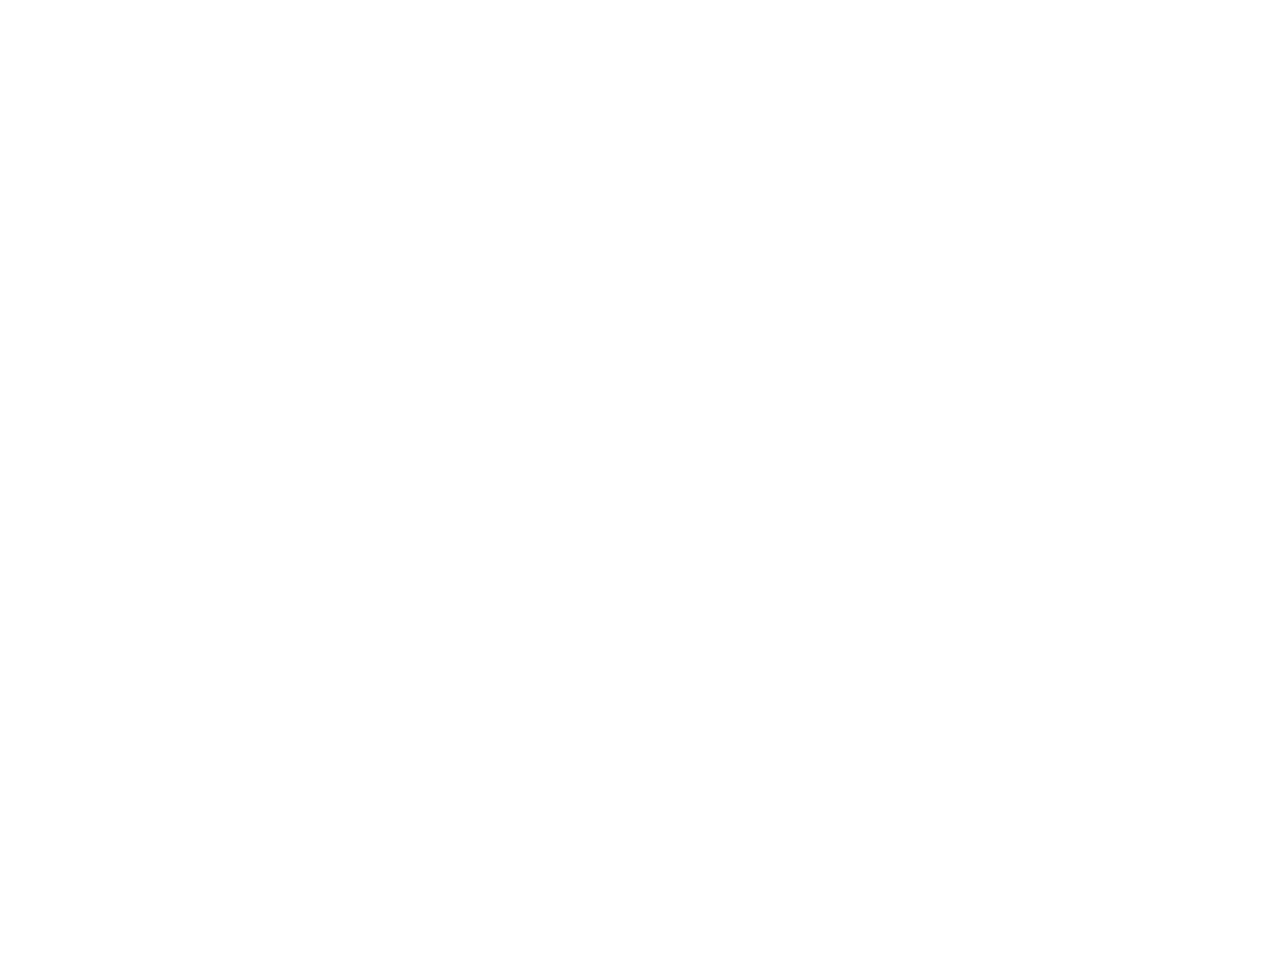

NameError: name 'padded' is not defined

In [13]:
plt.figure()
plt.imshow(padded)

In [442]:
pad = 500
padded = np.pad(data,pad)
band = 'r'
path='../data/ps1_skycell/'



for i in range(len(side_cells[0])):
    name = skycells.iloc[side_cells[0]].Name.values[i]
    side = side_cells[1][i]
    filename = f'rings.v3.{name}.stk.{band}.unconv.fits'
    hdul = fits.open(path+filename)
    if len(hdul) == 1:
        j = 0 
    else:
        j = 1
    buff = hdul[j].data

    if side == 0:
        padded[pad:-pad,:pad+10] = buff[:,-(pad+overlap):-overlap+10]
    elif side == 1:
        padded[-(pad+10):,pad:-pad] = buff[overlap-10:(pad+overlap),:]
    elif side == 2:
        padded[pad:-pad,-(pad+10):] = buff[:,overlap-10:(pad+overlap)]
    elif side == 3:
        padded[:pad+10,pad:-pad] = buff[-(pad+overlap):-overlap+10,:]

In [443]:

for i in range(len(corner_cells[0])):
    name = skycells.iloc[corner_cells[0]].Name.values[i]
    corner = corner_cells[1][i]
    filename = f'rings.v3.{name}.stk.{band}.unconv.fits'
    hdul = fits.open(path+filename)
    if len(hdul) == 1:
        j = 0 
    else:
        j = 1
    buff = hdul[j].data

    if corner == 0:
        padded[:(pad+10),:(pad+10)] = buff[-(pad+overlap):-overlap+10,-(pad+overlap):-overlap+10]
    elif corner == 1:
        padded[-(pad+10):,:(pad+10)] = buff[overlap-10:(pad+overlap),-(pad+overlap):-overlap+10]
    elif corner == 2:
        padded[-(pad+10):,-(pad+10):] = buff[overlap-10:(pad+overlap),overlap-10:(pad+overlap)]
    elif corner == 3:
        padded[:pad+10,-pad-10:] = buff[-(pad+overlap):-overlap+10,overlap-10:(pad+overlap)]

<IPython.core.display.Javascript object>


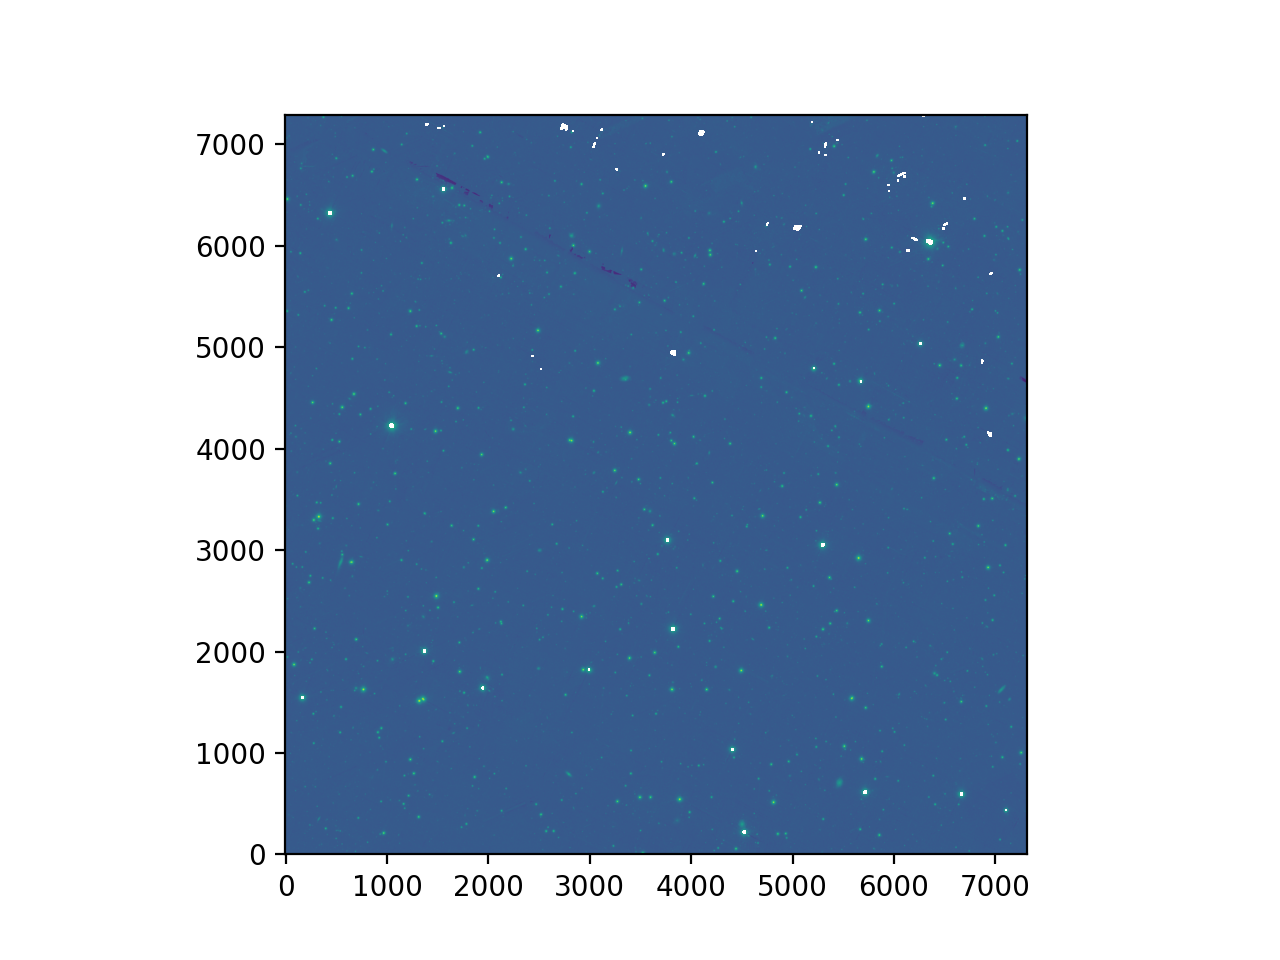

In [444]:
plt.figure()
plt.imshow(padded,origin='lower')

In [445]:
ra,dec = wcs.all_pix2world(data.shape[0]/2,data.shape[1]/2,0)
cat = query_ps1(ra,dec,0.6)

In [447]:
x,y = wcs.all_world2pix(cat['raMean'].values,cat['decMean'].values,0)

<IPython.core.display.Javascript object>


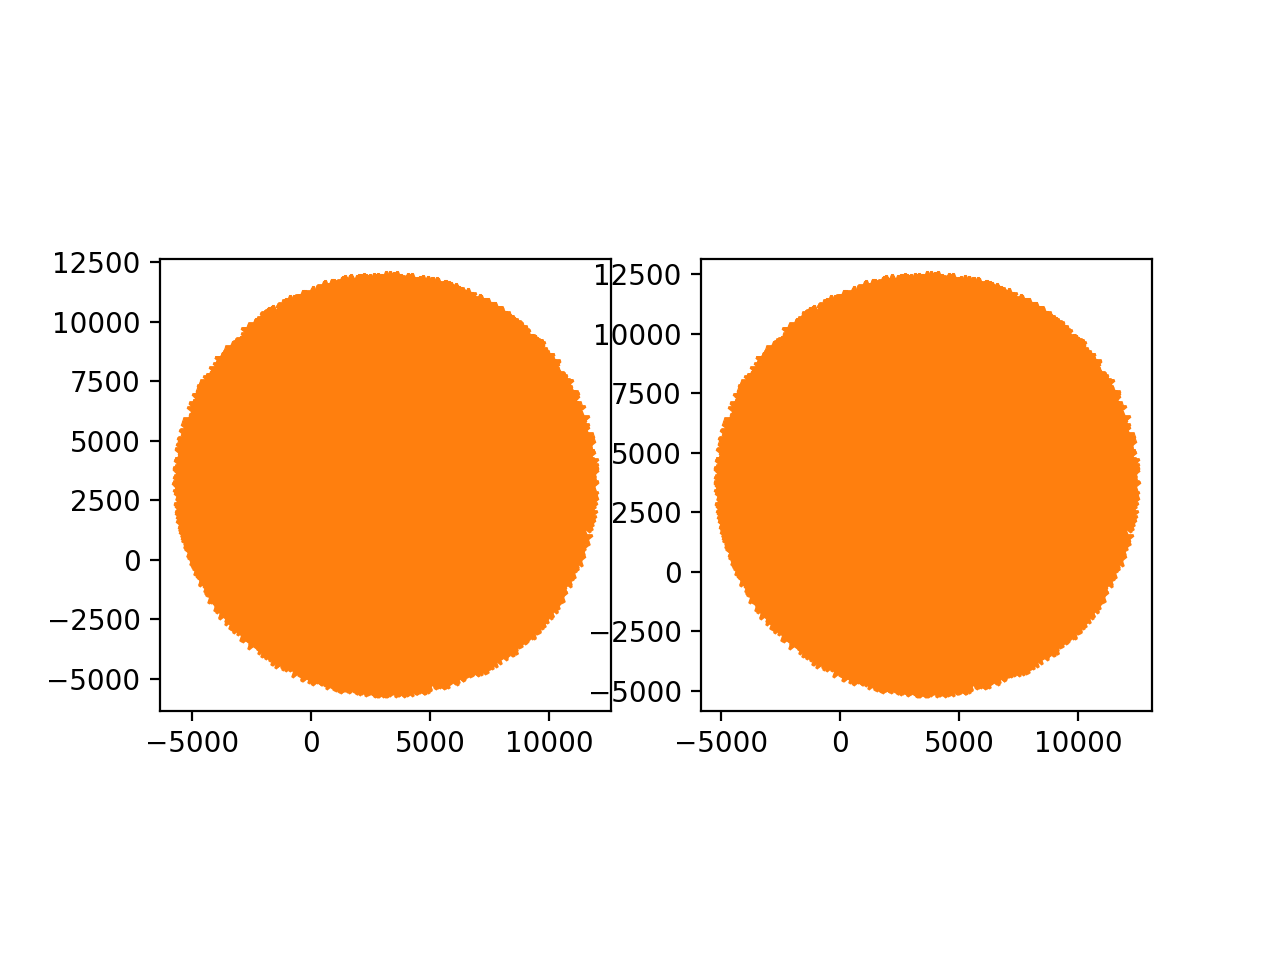

In [450]:
plt.figure()
plt.subplot(121)
plt.imshow(data,origin='lower')

plt.plot(x,y,'C1*')
plt.subplot(122)
plt.imshow(padded,origin='lower')
plt.plot(x+pad,y+pad,'C1*')

<IPython.core.display.Javascript object>


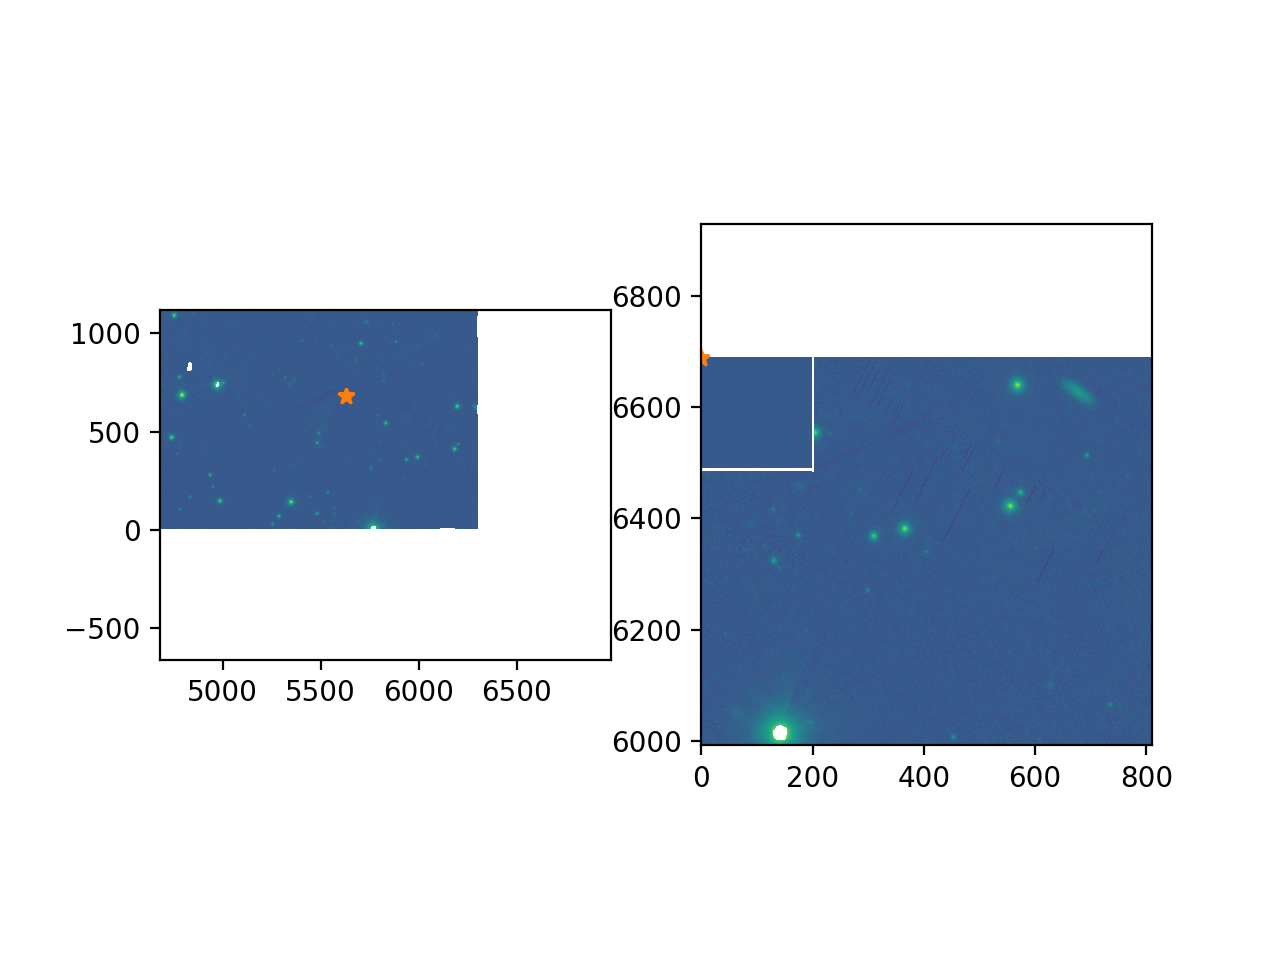

In [399]:
a = buff_wcs.all_world2pix(oversized_corners,0)
plt.figure()
plt.subplot(121)
plt.imshow(buff,origin='lower')
for i in a:
    plt.plot(i[0],i[1],'*')
plt.subplot(122)
plt.imshow(padded,origin='lower')
for i in oversize_corners:
    plt.plot(i[0]+pad,i[1]+pad,'*')

In [216]:
skycells.iloc[corner_cells[0]]

Name      Dist          RA        DEC  RA_Corner1  \
890  skycell.2246.002  1.047955  119.534511  44.176524  119.832951   
892  skycell.2246.004  1.568673  118.406763  44.184844  118.709701   
910  skycell.2246.022  0.461171  119.554687  44.982573  119.857301   
912  skycell.2246.024  1.255047  118.410798  44.991137  118.718041   

     DEC_Corner1  RA_Corner2  DEC_Corner2  RA_Corner3  DEC_Corner3  \
890    43.954382  119.846044    44.390407  119.233704    44.397967   
892    43.965613  118.714185    44.401816  118.101486    44.403328   
910    44.760148  119.870771    45.196472  119.249639    45.204253   
912    44.771708  118.722655    45.208214  118.101148    45.209770   

     RA_Corner4  DEC_Corner4  
890  119.225266    43.961824  
892  118.101665    43.967101  
910  119.240958    44.767809  
912  118.101332    44.773241

In [214]:
skycells.iloc[side_cells[0]]

Name      Dist          RA        DEC  RA_Corner1  \
891  skycell.2246.003  1.271180  118.970719  44.182071  119.271436   
900  skycell.2246.012  0.702171  119.544527  44.579480  119.845040   
902  skycell.2246.014  1.362172  118.408766  44.587921  118.713841   
911  skycell.2246.023  0.854523  118.982828  44.988282  119.287786   

     DEC_Corner1  RA_Corner2  DEC_Corner2  RA_Corner3  DEC_Corner3  \
891    43.961372  119.280227    44.397508  118.667648    44.402045   
900    44.357185  119.858320    44.793381  119.241614    44.801052   
902    44.368580  118.718390    44.804956  118.101318    44.806490   
911    44.767343  119.296831    45.203780  118.675449    45.208450   

     RA_Corner4  DEC_Corner4  
891  118.663517    43.965839  
900  119.233056    44.364736  
902  118.101500    44.370090  
911  118.671199    44.771941

<IPython.core.display.Javascript object>


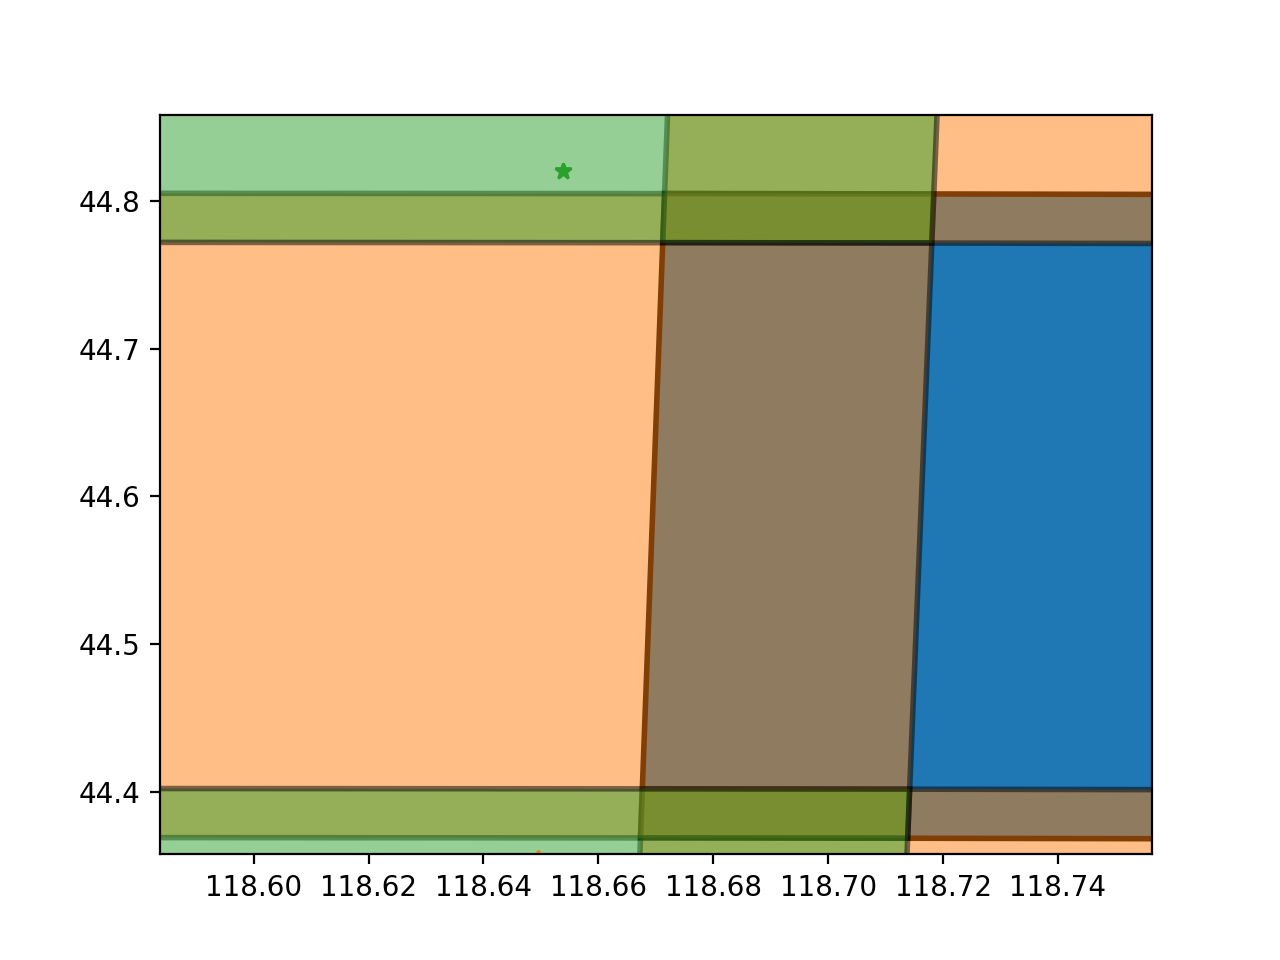

[119.29868039  44.35020551]
[118.64943399  44.35501523]
[118.65375633  44.82047399]
[119.30835158  44.81558353]


In [215]:
plt.figure()
#plt.plot(116,37)
for p in oversized_corners:
    print(p)
    plt.plot(p[0],p[1],'*')
for a in [path]:
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
        ]
    a = a.vertices
    b = np.vstack((a,a[0]))
    test = Path(b,codes=codes)
    patch = patches.PathPatch(test, facecolor='C0', lw=2,alpha=1)
    plt.gca().add_patch(patch)
    
for a in paths[side_cells[0]]:
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
        ]
    a = a.vertices
    b = np.vstack((a,a[0]))
    test = Path(b,codes=codes)
    patch = patches.PathPatch(test, facecolor='C1', lw=2,alpha=0.5)
    plt.gca().add_patch(patch)
    
for a in paths[corner_cells[0]]:
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
        ]
    a = a.vertices
    b = np.vstack((a,a[0]))
    test = Path(b,codes=codes)
    patch = patches.PathPatch(test, facecolor='C2', lw=2,alpha=0.5)
    plt.gca().add_patch(patch)
    


In [66]:
paths

[Path(array([[112.58535892,  37.95524113],
        [112.60079594,  38.39076099],
        [112.04297318,  38.40177089],
        [112.03084079,  37.96608068]]), None),
 Path(array([[112.59961163,  38.35753276],
        [112.61521972,  38.79300774],
        [112.05430934,  38.80417565],
        [112.04204239,  38.36852964]]), None),
 Path(array([[112.08442337,  38.3677866 ],
        [112.09694446,  38.80342106],
        [111.53566606,  38.81211343],
        [111.52649267,  38.37634581]]), None),
 Path(array([[112.61402225,  38.75978457],
        [112.62980427,  39.19517168],
        [112.06577195,  39.20649822],
        [112.0533682 ,  38.77093941]]), None),
 Path(array([[112.09598383,  38.7701857 ],
        [112.10864454,  39.20573291],
        [111.54423803,  39.21454877],
        [111.53496227,  38.77886789]]), None),
 Path(array([[111.57760234,  38.77830225],
        [111.58713552,  39.21397443],
        [111.02244802,  39.2202748 ],
        [111.01630484,  38.78450707]]), None),
 Pat